# Image Processing

this notebook is used to test and design functions for the vision pipeline. It it currently based on building basic pipeline functionalities: capture images, load data, parse data, save data and display data. Changes to buffpy will require restarting the kernel.

A quick note, this notebook is as imperfect as its author and may not include essential explanations. You will get the most out of this notebook if you spend time understanding each line in each cell. A great programmer will know how to break things by the end (not that you should). The best way for me to learn code is to add comments, thats why I intentionally left them out. By the end of this notebook the opencv and matplotlib docs will be your bestfriend.

The first cell is dedicated to importing everything we need. If you need imports in cells at the bottom of the page they should still be added here (keeping all our imports together).

In [1]:
import os
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from gdrive_handler import GD_Handler

# gd_handler = GD_Handler() # only need one for the whole notebook so initialize here

ANNOTATION_COLOR=(0,255,0)    # this value is a const throughout the notebook and will not change so we define it here also
ANNOTATION_THICKNESS=2

The purpose of this notebook is to demonstrate the process of developing our code. The first goal of this pipeline is capturing an image and uploading this image to a development machine or the cloud. This is all done on the bot and will not be in this notebook (this is done with buffpy). The next step after collecting data is to process that data. This notebook will walk through how to load images and labels and then tune algorithms to simulate perception. 

In [ ]:
gd_handler.downloadBatch('Yogi')
gd_handler.downloadBatch('Batch20') # download the Batch20 data

Here is an example of loading an image from the cloud.

In [2]:
yogi = cv2.imread('../data/yogimus.jpg')
cv2.imshow('sample', yogi)
cv2.waitKey(0)
cv2.destroyAllWindows()

GDrive handler Downloading from 1wAyKEnpN08ye2Qgb4MXyWNpu0xXzHI-Y
GDrive handler Downloading yogimus.jpg...


gd_handle will make using and administrating a database easy. Using the CU-Robotics google drive the handler will download batches into a temp data folder (which should be cleared when you aren't using it). TTry running the cell above a few times. The GD_Handler will also allow you to push data back to google drive (be careful with this!).

Next is an example of using  glob to load a batch of images from our data folder

In [3]:
filenames = glob.glob('../data/*.jpg')
images = [cv2.imread(file) for file in filenames]
print(f'Number of Images {len(images)}')
cv2.imshow('image0', images[0])
cv2.waitKey(0)
cv2.destroyAllWindows()

Number of Images 37


You might notice the same three lines used over and over to display single images. Here we will make a quick display function to reduce the line count.

In [4]:
def buffshow(title, image, wait=0):
    cv2.imshow(title, image)
    cv2.waitKey(wait)
    cv2.destroyAllWindows()

buffshow('image0', images[0])

The next function will read in the xml labels that pair with our data. 

In [5]:
filenames = glob.glob('../data/*.xml')
labels = [ET.parse(file) for file in filenames]
print(f'Number of Labels {len(labels)}')
print(labels[0])

Number of Labels 36


Lets take a closer look at the label objects we just created. Take a note of the way we print out the elements.

In [6]:
root = labels[0].getroot()
print(root.tag, root.attrib)

for i in range(len(root)):
    print(root[i].tag, root[i].attrib, root[i].text)
    for j in range(len(root[i])):
        print(f'\t', root[i][j].tag, root[i][j].attrib, root[i][j].text)
        for k in range(len(root[i][j])):
            print(f'\t\t', root[i][j][k].tag, root[i][j][k].attrib, root[i][j][k].text)

annotation {}
folder {} batch20
filename {} 969.jpg
path {} C:\Users\isaac\dataset\batch20\969.jpg
source {} 
		
	 database {} Unknown
size {} 
		
	 width {} 640
	 height {} 360
	 depth {} 3
segmented {} 0
object {} 
		
	 name {} armor
	 pose {} Unspecified
	 truncated {} 0
	 difficult {} 0
	 bndbox {} 
			
		 xmin {} 302
		 ymin {} 109
		 xmax {} 433
		 ymax {} 199


here we will try to display an image with annotations. The annotations will be the bounding box defined by the images label. Above we can see that these are stored under the object/bndbox so we'll need to access these elements before the values.

In [7]:
def get_bounding_from_label(label):
    bounds = []
    boundingboxes = label.findall('object')
    for boundary in boundingboxes:
        bound = boundary.find('bndbox')
        xmin = int(bound.find('xmin').text)
        ymin = int(bound.find('ymin').text)
        xmax = int(bound.find('xmax').text)
        ymax = int(bound.find('ymax').text)
        bounds.append([(xmin, ymin), (xmax, ymax)])
    return bounds
        
bounds = get_bounding_from_label(labels[0])
print(bounds)    

[[(302, 109), (433, 199)]]


In [8]:
def display_annotated_raw(data_point):
    image, label = data_point
    bounds = get_bounding_from_label(label)
    for bound in bounds:
        image = cv2.rectangle(image, bound[0], bound[1], ANNOTATION_COLOR, ANNOTATION_THICKNESS)
        
    buffshow('annotated', image)

for i in range(0,5): # try adjusting 0 and 5
    display_annotated_raw((images[i], labels[i]))

The data and labels will need to align for our dataset to be valid. Meaning each image needs a label. Keeping our modular approach to development we will create a few functions to handle this. The idea is that we write generic functions that could be used in as many aplications as possible (the higher level the function the harder this is). 

In [9]:
def load_images(path):
    filenames = glob.glob(path)
    return [(file.split('/')[-1], cv2.imread(file)) for file in filenames] # by saving the image with its filename we can properly match it to the data

def load_labels(path):
    filenames = glob.glob(path)
    return [ET.parse(file) for file in filenames]

def get_image_file_from_label(label):
    return label.find('filename').text
    
def load_data(path='../data'):
    images = load_images(os.path.join(path, '*.jpg'))
    labels = load_labels(os.path.join(path, '*.xml'))
    if len(images) - len(labels):
        print(f'mismatched: images {len(images)} != labels {len(labels)}')
        
    data = []
    for label in labels:
        file = get_image_file_from_label(label)
        for image in images:
            if image[0] == file:
                data.append((image[1], get_bounding_from_label(label)))
                
    return data

def display_annotated(data):
    image, bounds = data
    for bound in bounds:
        image = cv2.rectangle(image, bound[0], bound[1], ANNOTATION_COLOR, ANNOTATION_THICKNESS)
        
    buffshow('annotated', image)
    

data = load_data()
print(f'Number of data points: {len(data)}')
display_annotated(data[0])

mismatched: images 37 != labels 36
Number of data points: 36


A good thing to notice at this point is the complexity of our program. With N images and M labels we read a file N + M times. We also iterate through the labels and images to find their matches, this takes N * M cycles. So overall we end up with N + M +(N * M). This is really bad for a simple data loader. The reason we develop in the notebook is so we can easily see these things and fix them before pushing to buff-code. Think of this as a sandbox to show what kind of sand castle you can build, before we build it for real.

Potential Optimzation: As we read labels we extract the file it pairs with and then read the image, if any labels have a null or missing image throw them out.

We took a filepath to some data set, loaded the data and then displayed a visual. Since I'm lazy we are actually going to have the computer analyze the data set and tell us any interesting or notable things about it.

What should we look at?
  - size of the data set
  - center point of bounding boxes, where do they occur the most
  - size of bounding boxes, proportional to the distance
  - targets per image


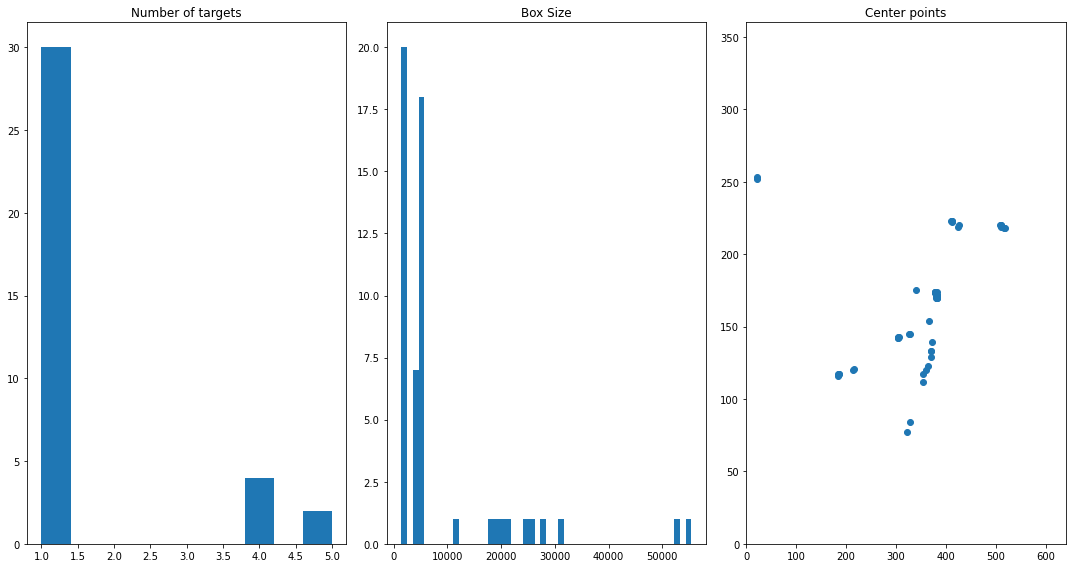

In [10]:
def parse_data(data):
    box_size = []
    n_targets = []
    center_x = []
    center_y = []
    for i,(image, label) in enumerate(data):
            n = 0
            for (x1,y1),(x2,y2) in label:
                n += 1
                h = np.abs(y2 - y1)
                w = np.abs(x2 - x1)
                box_size.append(w * h)
                center_x.append(x1 + int(w/2))
                center_y.append(y1 + int(h/2))
            n_targets.append(n)
            
    return box_size, n_targets, center_x, center_y

def analyze_data(data):
    s, n, cx, cy = parse_data(data)
    fig, axes = plt.subplots(1, 3, figsize=(15, 8), tight_layout=True)
    axes[0].hist(n, bins=10)
    axes[0].set_title('Number of targets')
    axes[1].hist(s, bins=50)
    axes[1].set_title('Box Size')
    axes[2].scatter(cx, cy)
    axes[2].set_title('Center points') # note that opencv images are bottom=640 and top=0, they will appear upside down here
    axes[2].set_ylim(bottom=0, top=360)
    axes[2].set_xlim(left=0, right=640)
    plt.show()
    
analyze_data(data)

We see that not every image has a single label, some have multiple. The sizes of the box we are looking for is also fairly consistent (increasing bin size can tell us even more). Lasty the center points of the bounding boxes are also mostly centered in the image. Is this data a good representation of what the robot will see during a battle?

This analysis tells us interesting things about our data set. Although we don't know if the data is actually valid. Next we'll look more closely at the data and try to do some re-labelling

In [18]:
new_label = []
x1 = None
x2 = None
y1 = None
y2 = None

# this labeler is set up to make xmin, xmax : mouse left click down, mouse left click up
# and then make ymin max in the same way, Once all four variables are filled it will save
# them in new_label. (click the xmin and drag to the xmax then release, repeat for y)
# when you mark the new label press q to close the image (do not click the red x).

def click_event(event, x, y, flags, param):
    global x1, x2, y1, y2, new_label
    # on press mark position
    if event == cv2.EVENT_LBUTTONDOWN:
        print('mouse down')
        # Take turns between reading width and height
        if x1 is None:
            x1 = x
        else:
            y1 = y

    elif event == cv2.EVENT_LBUTTONUP:
        print('mouse up')
        if x2 is None:
            x2 = x
        else:
            y2 = y
            
    if not y2 is None:
        print('recorded')
        new_label.append([(min(x1, x2), min(y1, y2)), (max(x1, x2), max(y1,y2))])
        x1 = None
        x2 = None
        y1 = None
        y2 = None
        
cv2.namedWindow("image")
cv2.setMouseCallback("image", click_event)

sample = data[-1]

buffshow("image", sample[0])
display_annotated((sample[0], new_label))

mouse down
mouse up
mouse down
mouse up
recorded


Heres an analytical solution to our clasification task. We use the color channels to guesstimate a threshold for the color, then mask out any part of the image not in this range. The next step is switching to the HSV color space, this allows for more robust color detection. After that we can start playing with crazy combos like a green threshold combined with a HV threshold (HSV not including the V). Keep in mind that masking and thresholding are expensive operations.

In [20]:
image1 = data[-1][0]

red_lower = (0,0,100) #bgr for red, lower boundary
red_upper = (80,80,255) #bgr for red, upper boundary
blue_lower = (100,0,0) #bgr for blue, lower boundary
blue_upper = (255,80,80) #bgr for blue, upper boundary

red_mask = cv2.inRange(image1, red_lower, red_upper)
blue_mask = cv2.inRange(image1, blue_lower, blue_upper)

red_output = cv2.bitwise_and(image1, image1, mask=red_mask)
blue_output = cv2.bitwise_and(image1, image1, mask=blue_mask)

buffshow('red-detect', red_output)
buffshow('redmask', red_mask)
buffshow('blue-detect', blue_output)